In [1]:
# Importing necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from bokeh.plotting import figure, output_file, save, show
from bokeh.models import Range1d, LinearAxis, FactorRange, ColumnDataSource, LabelSet, LinearColorMapper
from bokeh.io import output_notebook
from matplotlib import gridspec, colors
from bokeh.palettes import Greys256

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.transform import transform

import matplotlib.pyplot as plt
import numpy as np

2023-07-14 07:36:27.807525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 07:36:28.116315: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 07:36:28.118264: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 07:36:30.552189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_sample_digits(x_train, y_train):
    # Convert one-hot encoded y_train back to label format
    y_train_labels = np.argmax(y_train.numpy(), axis=1)
    
    # Convert x_train to numpy
    x_train_np = x_train.numpy()

    # Prepare an example of each digit
    examples = {}
    for i in range(10):
        examples[i] = x_train_np[np.argwhere(y_train_labels == i)[0][0]].reshape(28, 28)
        
    # Prepare the figure
    fig, axes = plt.subplots(2, 5, figsize=(10,4))

    for i in range(10):
        ax = axes[i//5, i%5]
        ax.imshow(examples[i], cmap='gray', aspect='auto')
        ax.axis('off')  # hide the axes ticks
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # Check/Create model directory
    output_file_path = f"generated/mnist_examples.png"
    os.makedirs(output_file_path, exist_ok=True)
    
    #Save figure
    plt.savefig(output_file_path)

In [3]:
# Plot loss and accuracy over epochs
def plot_metrics(loss_per_epoch, accuracy_per_epoch):
    # Create a new plot with a range for the loss [left]
    p = figure(x_axis_label='Epochs', y_axis_label='Loss')
    
    output_notebook()
    
    # Set range for loss axis
    loss_max = max(loss_per_epoch) + 0.05 * max(loss_per_epoch)  # for example, add 5% as a padding to the max value
    p.y_range = Range1d(0, loss_max)  # adjust according to your loss data
    
    # Plot loss
    p.line(np.arange(len(loss_per_epoch)) + 1, loss_per_epoch, legend_label="Loss", line_color="red", line_width = 3)
    
    # Create a new range for the accuracy [right]
    p.extra_y_ranges = {"AccuracyRange": Range1d(start=0, end=100)} # Update the range
    p.add_layout(LinearAxis(y_range_name="AccuracyRange", axis_label="Accuracy (%)"), 'right') # Update the label

    # Scale accuracy values to percentage and plot
    accuracy_per_epoch_percentage = [acc * 100 for acc in accuracy_per_epoch] # Scale accuracy
    p.line(np.arange(len(accuracy_per_epoch_percentage)) + 1, accuracy_per_epoch_percentage, legend_label="Accuracy", line_color="blue", y_range_name="AccuracyRange", line_width = 3) # Plot scaled accuracy
    
    # Remove the grid
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    # Check/Create model directory
    output_file_path = f"generated/metrics_plot.html"
    os.makedirs(output_file_path, exist_ok=True)
    
    # Save the plot
    output_file(output_file_path)
    show(p)


def plot_metrics_plt(loss_per_epoch, accuracy_per_epoch):
    fig, ax1 = plt.subplots()

    # Plot loss
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    loss_line, = ax1.plot(np.arange(len(loss_per_epoch)) + 1, loss_per_epoch, color='red', alpha=0.5, linewidth=3, label = "Loss")
    ax1.tick_params(axis='y')

    # Create a new axis for the accuracy plot
    ax2 = ax1.twinx()
    # Scale accuracy values to percentage and plot
    accuracy_per_epoch_percentage = [acc * 100 for acc in accuracy_per_epoch]  # Scale accuracy
    ax2.set_ylabel('Accuracy (%)')  # we already handled the x-label with ax1
    accuracy_line, = ax2.plot(np.arange(len(accuracy_per_epoch_percentage)) + 1, accuracy_per_epoch_percentage, color='navy', alpha=0.5, linewidth=3, label = "Accuracy")
    ax2.tick_params(axis='y')
    ax2.set_ylim([0, 100])
    
    # Get lines and labels for legend
    lines = [loss_line, accuracy_line]
    labels = [l.get_label() for l in lines]
    
    # Create legend
    fig.legend(lines, labels, loc='center right')
    
    # Remove top and right border
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [20]:
def plot_model_output(model, output_digit, instance, x_data, y_data):
    # Convert one-hot encoded y_train back to label format
    y_labels = np.argmax(y_data, axis=1)
    
    output_notebook()
    
    # Find the first instance of '0'
    zero_index = np.argwhere(y_labels == output_digit)[instance][0]
    zero_input = tf.reshape(x_data[zero_index], (1, -1)) # Reshape it to match model input shape

    # Calculate model output
    output = model(zero_input).numpy()[0]

    # Prepare data for bar chart
    digits = [str(i) for i in range(10)][::-1]
    output_values = output.tolist()[::-1]
    
    # Format output values to have 2 decimal places
    formatted_output_values = [f"{val:.2E}" for val in output_values]

    # Create a new figure with a white background
    p = figure(y_range=FactorRange(factors=digits), 
               width=500, 
               title="Model Output for First Instance of Digit 0",
               y_axis_label='Digits',
               x_axis_label='Model Output (~Probability)',
               background_fill_color="white")

    # Create a ColumnDataSource with the data
    source = ColumnDataSource(data=dict(digits=digits, output_values=output_values, formatted_output_values=formatted_output_values))

    # Add a horizontal bar chart to the figure with black bars
    p.hbar(y='digits', right='output_values', height=0.5, color="black", source=source)

    # Create labels for the bars with color based on a condition
    color_mapper = LinearColorMapper(palette=['black', 'white'], low=min(output_values), high=max(output_values))
    labels = LabelSet(x='output_values', y='digits', text='formatted_output_values', level='annotation',
                      x_offset=5, y_offset=-10, text_align='left', text_color=transform('output_values', color_mapper), source=source)
    
    print(formatted_output_values)
    # Add labels to the plot
    p.add_layout(labels)

    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    p.xaxis.major_label_text_font_size = "15pt"
    p.yaxis.major_label_text_font_size = "15pt"

    # Remove the grid
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    output_file_path = f"generated/output_plot_for_{output_digit}.html"
    
    # Check/Create model directory
    os.makedirs(output_file_path, exist_ok=True)

    # Save the plot
    output_file(output_file_path)
    show(p)

In [5]:
# Step 1: Load and prepare the MNIST dataset.
def load_data():
    # This data is already split into train and test datasets.
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Reshape and normalize the images to feed into the neural network.
    x_train, x_test = tf.cast(x_train.reshape(-1, 784)/255.0, tf.float32), \
    tf.cast(x_test.reshape(-1, 784)/255.0, tf.float32)

    # Convert labels to one-hot vectors. This is necessary as our output layer 
    # will have 10 neurons, one for each digit from 0 to 9.
    y_train, y_test = tf.one_hot(y_train, depth=10), tf.one_hot(y_test, depth=10)
    
    return x_train, y_train, x_test, y_test

In [6]:
# Step 2: Define the model
def define_model():
    W = tf.Variable(tf.random.normal([784, 10]), name="weights", dtype = tf.float32)
    b = tf.Variable(tf.zeros([10]), name="biases",  dtype = tf.float32)
    return W, b

In [7]:
# Step 3: Define the model's computations
def model(x, W, b):
    return tf.nn.softmax(tf.matmul(x, W) + b)

In [8]:
# Step 4: Define the loss function
def compute_loss(y_true, y_pred):
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=[1]))

In [9]:
# Step 5: Define the training step
learning_rate = 0.01
@tf.function
def train_step(x, y, W, b):
    with tf.GradientTape() as tape:
        y_pred = model(x, W, b)
        current_loss = compute_loss(y, y_pred)
    gradients = tape.gradient(current_loss, [W, b])
    W.assign_sub(learning_rate * gradients[0])  # update weights
    b.assign_sub(learning_rate * gradients[1])  # update biases
    return current_loss


In [10]:
@tf.function
def compute_model(x, W, b):
    return model(x, W, b)

# Define the accuracy calculation
def compute_accuracy(y_true, y_pred):
    correct_predictions = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [11]:
def calculate_initial_loss(x, y, batch_size):
    
    for _ in range(len(x_train)//batch_size):
        y_pred = model(x, W, b)
        current_loss = compute_loss(y, y_pred)
            
    return current_loss
    

In [12]:
def train_model(epochs, batch_size, x_train, y_train):
    # Define model
    W, b = define_model()

    # Store loss and accuracy for each epoch
    loss_per_epoch     = []
    accuracy_per_epoch = []
    
    # Training loop
    for epoch in range(epochs):
        i = 0
        while i < len(x_train):
            start = i
            end = i + batch_size
            x_batch = x_train[start:end]
            y_batch = y_train[start:end]
            current_loss = train_step(x_batch, y_batch, W, b)
            i += batch_size

        # Compute loss and accuracy for each epoch
        y_pred = compute_model(x_test, W, b)
        loss_per_epoch.append(current_loss)
        accuracy_per_epoch.append(compute_accuracy(y_test, y_pred))
        print(f'Epoch {epoch+1} completed')
        
    return loss_per_epoch, accuracy_per_epoch, W, b

In [13]:
x_train, y_train, x_test, y_test = load_data()

2023-07-14 07:36:36.666371: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376320000 exceeds 10% of free system memory.
2023-07-14 07:36:37.074319: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-07-14 07:36:37.305493: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62720000 exceeds 10% of free system memory.
2023-07-14 07:36:37.359620: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


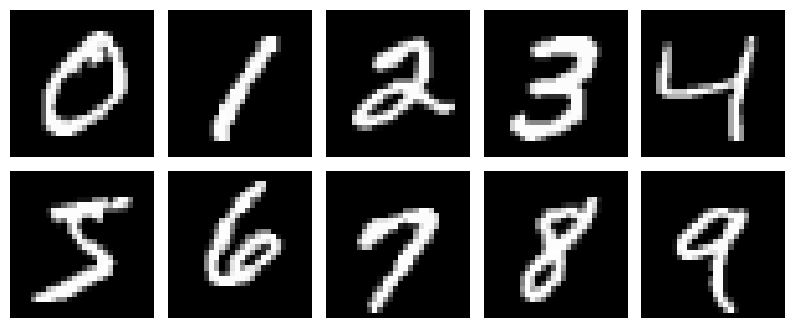

In [14]:
plot_sample_digits(x_train, y_train)

In [15]:
loss_per_epoch, accuracy_per_epoch, W, b = train_model(15, 32, x_train, y_train)

Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed


Loading BokehJS ...

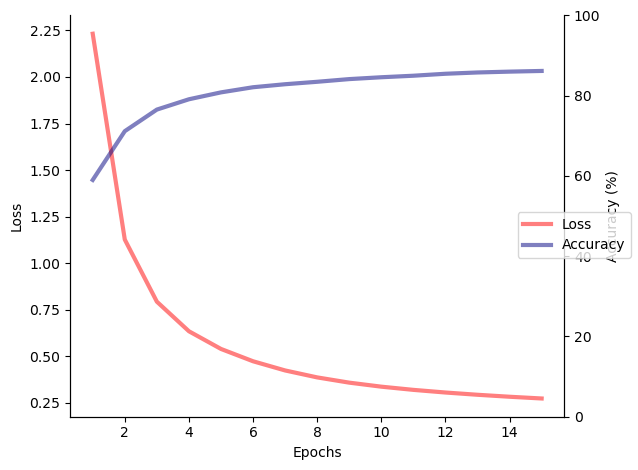

In [16]:
plot_metrics([l.numpy() for l in loss_per_epoch], [a.numpy() for a in accuracy_per_epoch])
plot_metrics_plt([l.numpy() for l in loss_per_epoch], [a.numpy() for a in accuracy_per_epoch])

In [23]:
model_fn = lambda x: model(x, W, b)

for i in range(10):
    plot_model_output(model_fn, i, 2, x_train, y_train)

Loading BokehJS ...

['3.83E-07', '1.86E-03', '3.02E-12', '2.26E-05', '7.09E-04', '3.70E-13', '4.93E-06', '6.78E-07', '2.00E-15', '9.97E-01']


Loading BokehJS ...

['6.90E-04', '2.38E-05', '2.28E-07', '1.57E-07', '3.60E-04', '5.75E-06', '6.75E-03', '3.74E-07', '9.92E-01', '8.55E-11']


Loading BokehJS ...

['9.68E-15', '1.94E-05', '2.18E-21', '1.68E-12', '1.53E-07', '4.03E-19', '3.79E-01', '6.21E-01', '4.13E-15', '5.35E-08']


Loading BokehJS ...

['3.81E-14', '2.47E-12', '1.07E-14', '1.08E-19', '2.54E-08', '1.56E-15', '1.00E+00', '5.39E-14', '5.20E-20', '2.13E-14']


Loading BokehJS ...

['3.08E-06', '5.19E-08', '3.38E-14', '1.58E-11', '1.11E-12', '1.00E+00', '2.58E-12', '3.18E-13', '1.58E-16', '1.32E-15']


Loading BokehJS ...

['3.82E-09', '7.73E-05', '2.35E-06', '2.20E-08', '9.97E-01', '3.72E-07', '2.34E-03', '3.79E-05', '7.89E-05', '1.81E-07']


Loading BokehJS ...

['3.46E-08', '1.88E-09', '4.59E-13', '1.00E+00', '4.96E-05', '1.91E-06', '5.38E-11', '8.62E-06', '1.02E-15', '3.07E-07']


Loading BokehJS ...

['2.42E-01', '1.98E-07', '6.51E-01', '5.88E-06', '1.23E-08', '2.41E-02', '7.38E-07', '8.32E-02', '4.57E-06', '1.49E-07']


Loading BokehJS ...

['2.53E-04', '9.99E-01', '7.17E-08', '3.09E-08', '4.34E-04', '8.33E-11', '5.38E-05', '1.52E-06', '6.77E-09', '1.84E-09']


Loading BokehJS ...

['9.28E-01', '5.66E-02', '1.09E-02', '1.92E-06', '1.03E-03', '1.69E-03', '1.69E-03', '2.61E-04', '1.61E-04', '1.38E-06']


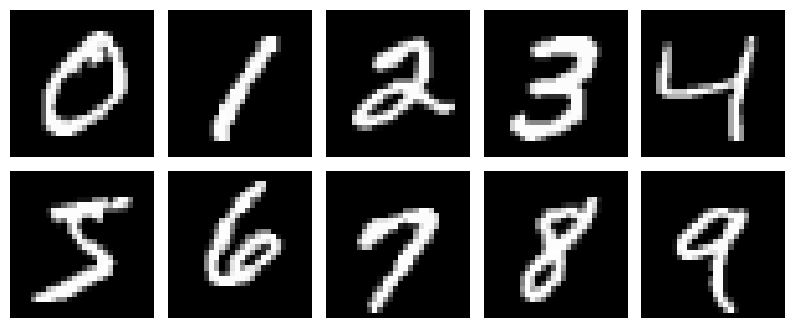

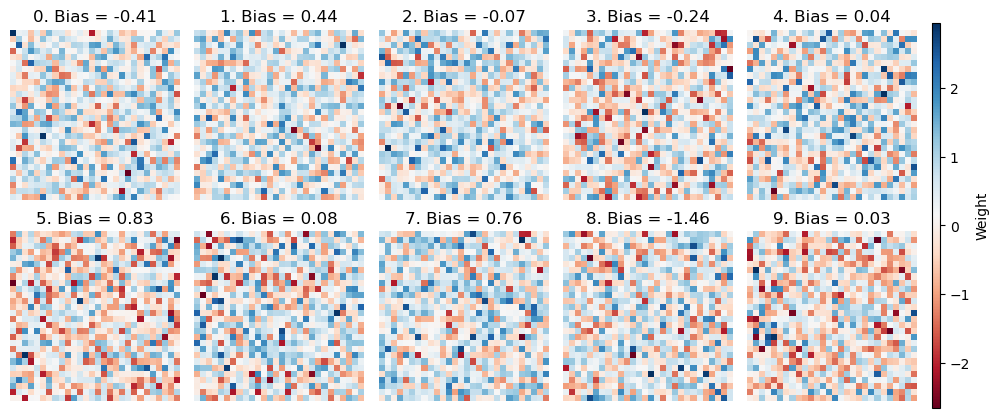

In [18]:
def plot_weight_maps(W, b):
    # Convert TensorFlow variables to numpy
    W_np = W.numpy()
    b_np = b.numpy()

    # Create grid for subplots and colorbar
    fig = plt.figure(figsize=(12,5))
    gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.05])
    gs.update(wspace=0.1, hspace=0.1)  # set the spacing between axes.

    # Reshape weight matrix into "maps" and plot them
    cmap = plt.get_cmap('RdBu')
    norm = colors.Normalize(vmin=b_np.min(), vmax=b_np.max())  # normalize biases to colormap range
    
    for i in range(10):
        weight_map = W_np[:, i].reshape(28, 28)  # reshape weights
        ax = plt.subplot(gs[i//5, i%5])
        im = ax.imshow(weight_map, cmap=cmap)  # use a diverging colormap to show negative and positive weights
        ax.axis('off')  # hide the axes ticks
        color = cmap(norm(b_np[i]))  # map bias value to colormap
        ax.set_title(f'{i}. Bias = {b_np[i]:.2f}')  # add class label and bias value, colored by bias value

    # Create an axis for the colorbar on the right side
    cbar_ax = plt.subplot(gs[:, -1])
    cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
    cb.set_label('Weight')  # add colorbar label
    
    # Check/Create model directory
    output_file_path = f"generated/weight_maps.png"
    os.makedirs(output_file_path, exist_ok=True)
    
    #Save figure
    plt.savefig(output_file_path)

plot_sample_digits(x_train, y_train)
plot_weight_maps(W, b)